In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, fbeta_score, classification_report, log_loss
%matplotlib inline

In [7]:
df = pd.read_csv('language_classification.csv')

In [8]:
df.head(5)

,text,language
0,Ship shape and Bristol fashion,English
1,Know the ropes,English
2,Graveyard shift,English
3,Milk of human kindness,English
4,Touch with a barge-pole - Wouldn't,English


In [14]:
languages = pd.unique(df.language.values)
print(languages)

['English' 'Afrikaans' 'Nederlands']


Text(0,0.5,'Frequency')

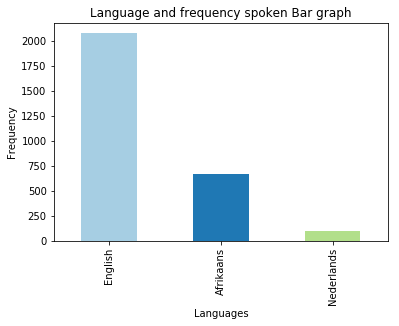

In [23]:
df.language.value_counts().plot(kind='bar',  color=[plt.cm.Paired(np.arange(len(df)))], stacked=True)
plt.title('Language and frequency spoken Bar graph')
plt.xlabel('Languages')
plt.ylabel('Frequency')

Text(0,0.5,'Density')

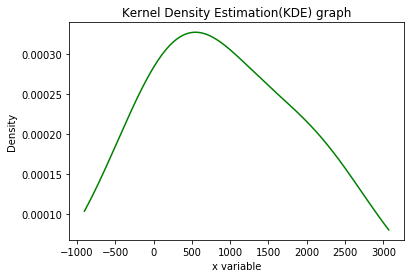

In [24]:
df.language.value_counts().plot(kind='kde', color='g')
plt.title('Kernel Density Estimation(KDE) graph')
plt.xlabel('x variable')
plt.ylabel('Density')

In [29]:
df = df.dropna()

In [30]:
vectorizer = CountVectorizer()
X_vectorizer = vectorizer.fit_transform(df.text.values)
print(X_vectorizer.shape)

(2761, 4342)


In [31]:
X_tfidf = TfidfTransformer().fit_transform(X_vectorizer)
print(X_tfidf.shape)

(2761, 4342)


In [32]:
X = X_tfidf
y = df.language.values
print(y.shape)

(2761,)


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [34]:
clf = RandomForestClassifier().fit(X_train, y_train)

In [35]:
print(clf.feature_importances_)
print(clf.get_params())
print(clf.max_features)

[ 0.          0.          0.         ...,  0.00153212  0.          0.        ]
{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': 1, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
auto


In [36]:
y_predicted = clf.predict(X_test)

In [38]:
print(accuracy_score(y_true=y_test, y_pred=y_predicted))

0.967105263158


In [41]:
labels = ['English','Afrikaans','Nederlands']
print(confusion_matrix(y_test, y_predicted, labels))

[[689   1   0]
 [ 12 191   0]
 [ 11   6   2]]


Text(0,0.5,'True')

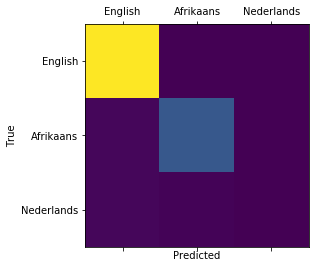

In [47]:
cm = confusion_matrix(y_test, y_predicted, labels)
plt.matshow(cm)
plt.xticks(range(3),labels)
plt.yticks(range(3), labels)
plt.xlabel('Predicted')
plt.ylabel('True')

In [56]:
print(f1_score(y_pred=y_predicted, y_true=y_test, average=None))
print(fbeta_score(y_pred=y_predicted, y_true=y_test, average=None, beta=0.99))

[ 0.95261845  0.9828816   0.19047619]
[ 0.95273784  0.98272662  0.19203856]


In [58]:
print(classification_report(y_true=y_test, y_pred=y_predicted))

             precision    recall  f1-score   support

  Afrikaans       0.96      0.94      0.95       203
    English       0.97      1.00      0.98       690
 Nederlands       1.00      0.11      0.19        19

avg / total       0.97      0.97      0.96       912



In [65]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import adjusted_rand_score

## Evaluating the K in terms of text Explorations

In [74]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df.text.values)

In [75]:
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    
    # Fit model to samples
    model.fit(X)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

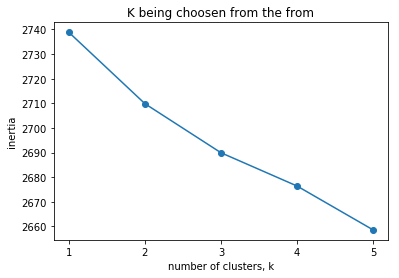

In [77]:
plt.plot(ks, inertias, '-o')
plt.title('K being choosen from the from')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [78]:
model = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=1)
labels = model.fit_predict(X)

In [79]:
df_k = pd.DataFrame({'labels': labels, 'languages': df.language.values})
ct = pd.crosstab(df_k['labels'], df_k['languages'])

In [80]:
print(ct)

languages  Afrikaans  English  Nederlands
labels                                   
0                468     1445          67
1                  0      524           0
2                171       86           0


In [81]:
from scipy.cluster.hierarchy import linkage, dendrogram

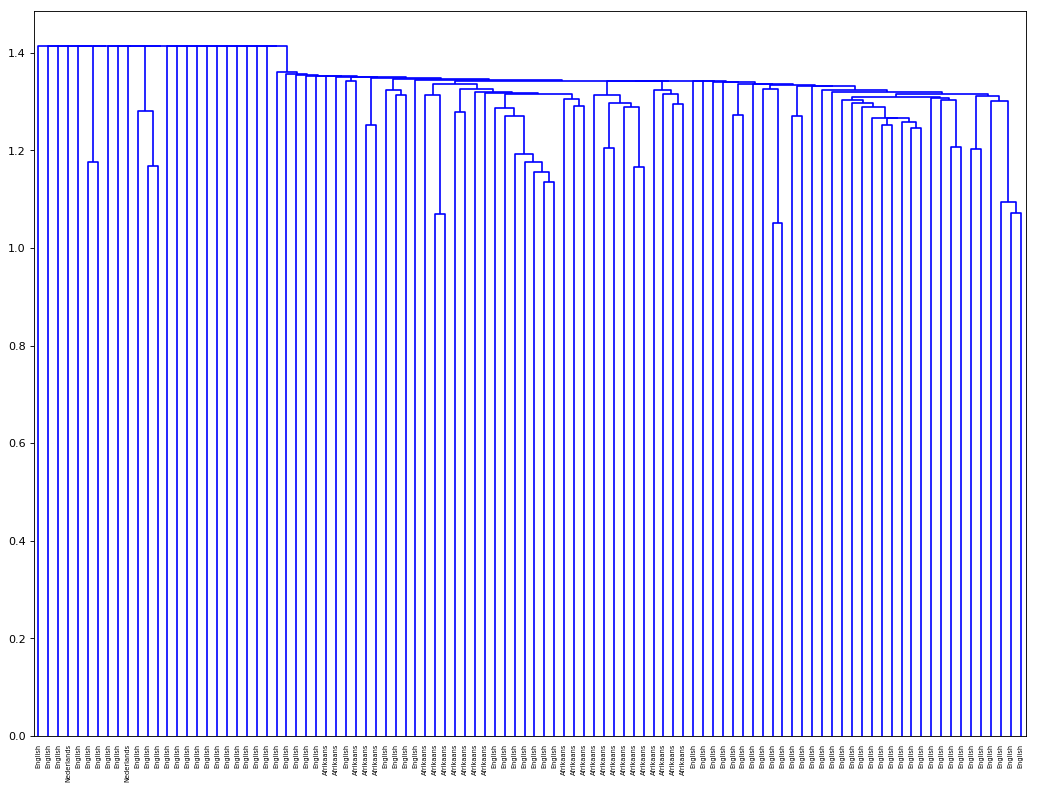

In [92]:
mergings = linkage(X.toarray()[:100], method='single')

# Plot the dendrogram, using varieties as labels
plt.figure(num=None, figsize=(16, 12), dpi=80)
dendrogram(mergings,
           labels=df.language.values[:100],
           leaf_rotation=90,
           leaf_font_size=6,
)
plt.show()

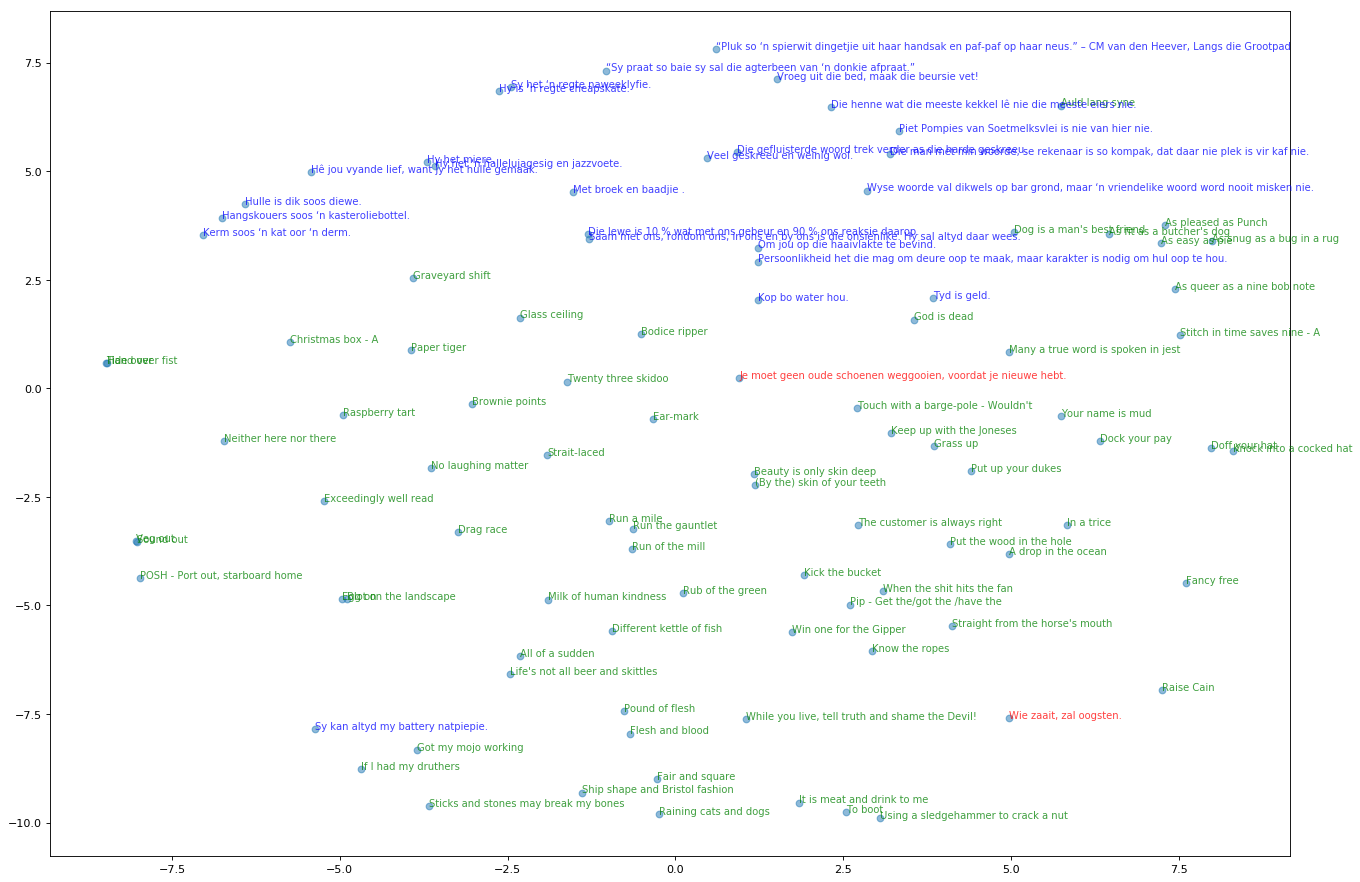

In [104]:
from sklearn.manifold import TSNE

model = TSNE(learning_rate=50)
tsne_features = model.fit_transform(X.toarray()[:100])
xs = tsne_features[:,0]
ys = tsne_features[:,1]

colors = {'English':'g', 'Nederlands':'r', 'Afrikaans':'b'}
count = 0
plt.figure(num=None, figsize=(20, 14), dpi=80)
plt.scatter(xs, ys, alpha=0.5)
for x, y, company in zip(xs, ys, df.text.values[:100]):
    plt.annotate(company, (x, y), fontsize=9, alpha=0.75, color=colors[df.language.values[count]])
    count += 1
plt.show()

## Clustering and Classification

In [141]:
df = pd.read_excel('clustering_and_classification.xlsx')
true = pd.read_csv('customers.csv')

In [142]:
true_regions = true.Region.astype('category')

In [146]:
true_regions

0      3
1      3
2      3
3      3
4      3
5      3
6      3
7      3
8      3
9      3
10     3
11     3
12     3
13     3
14     3
15     3
16     3
17     3
18     3
19     3
20     3
21     3
22     3
23     3
24     3
25     3
26     3
27     3
28     3
29     3
      ..
410    3
411    3
412    3
413    3
414    3
415    3
416    3
417    3
418    3
419    3
420    3
421    3
422    3
423    3
424    3
425    3
426    3
427    3
428    3
429    3
430    3
431    3
432    3
433    3
434    3
435    3
436    3
437    3
438    3
439    3
Name: Region, Length: 440, dtype: category
Categories (3, int64): [1, 2, 3]

In [109]:
df.head()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,12669,9656,7561,214,2674,1338
1,7057,9810,9568,1762,3293,1776
2,6353,8808,7684,2405,3516,7844
3,13265,1196,4221,6404,507,1788
4,22615,5410,7198,3915,1777,5185


In [119]:
ks = range(1, 6)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k, max_iter=10000)
    
    # Fit model to samples
    model.fit(df.values)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

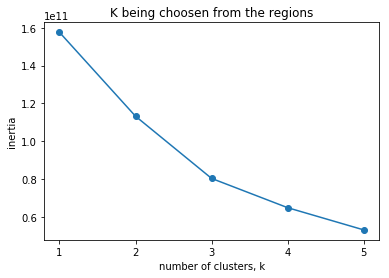

In [120]:
plt.plot(ks, inertias, '-o')
plt.title('K being choosen from the regions')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

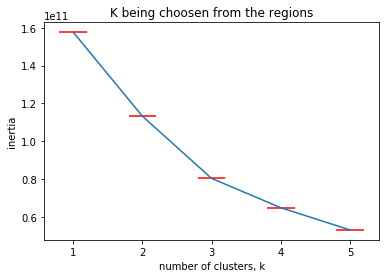

In [121]:
plt.errorbar(ks, inertias, xerr=0.2, yerr=0.4, ecolor='r')
plt.title('K being choosen from the regions')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [132]:
np.random.seed(1)
model = KMeans(n_clusters=3, init='k-means++', max_iter=10000, n_init=1)
labels = model.fit_predict(df.values)

In [148]:
df['Region'] = labels

In [150]:
model = KMeans(n_clusters=2, init='k-means++', max_iter=10000, n_init=1)
labels = model.fit_predict(df.values)

In [152]:
labels + 1

array([2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 1,
       1, 1, 2, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 1, 2, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2,
       1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2,

In [154]:
print(accuracy_score(y_true=true.Channel.values, y_pred=(labels + 1)))

0.406818181818


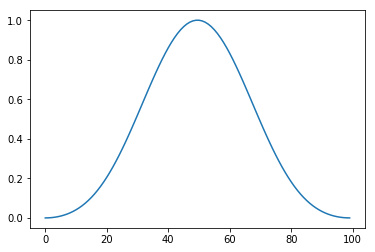

In [161]:
window = np.blackman(100)
plt.plot(window)